In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import MultipleLocator
import matplotlib.patches as mpatches

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

In [3]:
def paramDis_pnorm(s, sre, p):
    maps = lambda k : s[k] if k in s else 0.0
    mapfs = lambda k : sre[k] if k in sre else 0.0
    iss=lambda k: 1.0 if k in s else 0.0
    allKeys = set(s.keys()).union(sre.keys())
    ans = 0.0
    idea = 0.0
    for k in allKeys:
        ans += abs(maps(k) - mapfs(k))**p
        idea += abs(iss(k))**p
    return ans / idea


def getAllError_calls(filename):
    with open(filename) as f:
        data = json.load(f)
    originalHam = data[0]
#     print(originalHam)
    calls = [data[i][1] + data[i][2] for i in range(1, len(data))]
    errors = [ paramDis_pnorm(originalHam, data[i][0], 1) for i in range(1, alen(data))]
    return errors, calls

def getAllError_calls_multiH(filename):
    calls = []
    errors = []
    hamLs = []
    with open(filename) as f:
        data = json.load(f)
    for case in data:
        if type(case) == dict:
            originalHam = case
        else :
            # calls.append(case[1] + case[2])
            calls.append(8*case[1])
            errors.append(paramDis_pnorm(originalHam, case[0], 1))
            hamLs.append(case[0])
    return errors, calls, originalHam, hamLs                      

In [4]:
def num2PauliLabel(x, n):
    label_map = {0: 'I', 1: 'X', 2: 'Z', 3: 'Y'}
    outstr = ""
    for i in range(n):
        outstr += label_map[x%4]
        x = x // 4
    return outstr

def addSign(stri, num):
    if num > 0:
        return '+'+stri
    else:
        return '-'+stri

def getAllError_calls_multiH_withmin(filename):
    calls = []
    errors = []
    minDis = 10
    minHamLs = []
    minHam = 0
    with open(filename) as f:
        data = json.load(f)
    for case in data:
        if type(case) == dict:
            originalHam = case
            minDis = 10
            if minHam != 0:
                minHamLs.append(minHam)
        else:
            calls.append(8*case[1])
            er = paramDis_pnorm(originalHam, case[0], 1)
            if er < minDis:
                minHam = (er, originalHam, case[0])
                minDs = er
#                 print(er)
            errors.append(er)
    minHamLs.append(minHam)
    return errors, calls, minHamLs

In [5]:
filenames = ["../data/H4Rounds=10_b=7_test.json", "../data/H4Rounds=10_b=7_test4.json"]

errors, calls, originalHam, hamLs = getAllError_calls_multiH(filenames[0])
errors1, calls1, _, hamLs1 = getAllError_calls_multiH(filenames[1])

errors.extend(errors1)
calls.extend(calls1)
hamLs.extend(hamLs1)

topNum = 50
vote = 5
rounds = 8

orgsorted = {k: v1 for k, v1 in sorted(originalHam.items(), key=lambda item: abs(item[1]), reverse=True)}
orgTop = list(orgsorted.items())[:topNum]
orgHam = []
reConHam = []
reStd = []
labels = []
signs = []
termsLs = []
for k, v in orgTop:
    count = 1
    aftervote = []
    total = []
    for ham in hamLs:
        if count % vote == 0:
#             print(termsLs)
            termsign = np.sign(np.sum(np.sign(termsLs)))
            termAve = np.mean(np.abs(termsLs))
            aftervote.append(termsign * termAve)
            termsLs = []
        count += 1
        if k in ham:
            termsLs.append(ham[k])
            total.append(ham[k])
    termsLs = []
#     print(aftervote)
    termsign = np.sign(np.sum(np.sign(aftervote)))
    reConHam.append(np.mean(aftervote))
    reStd.append(np.std(aftervote))
    labels.append(k)
    orgHam.append(v)
    signs.append(termsign)
#     print(len(termsLs))
x = np.arange(len(labels))

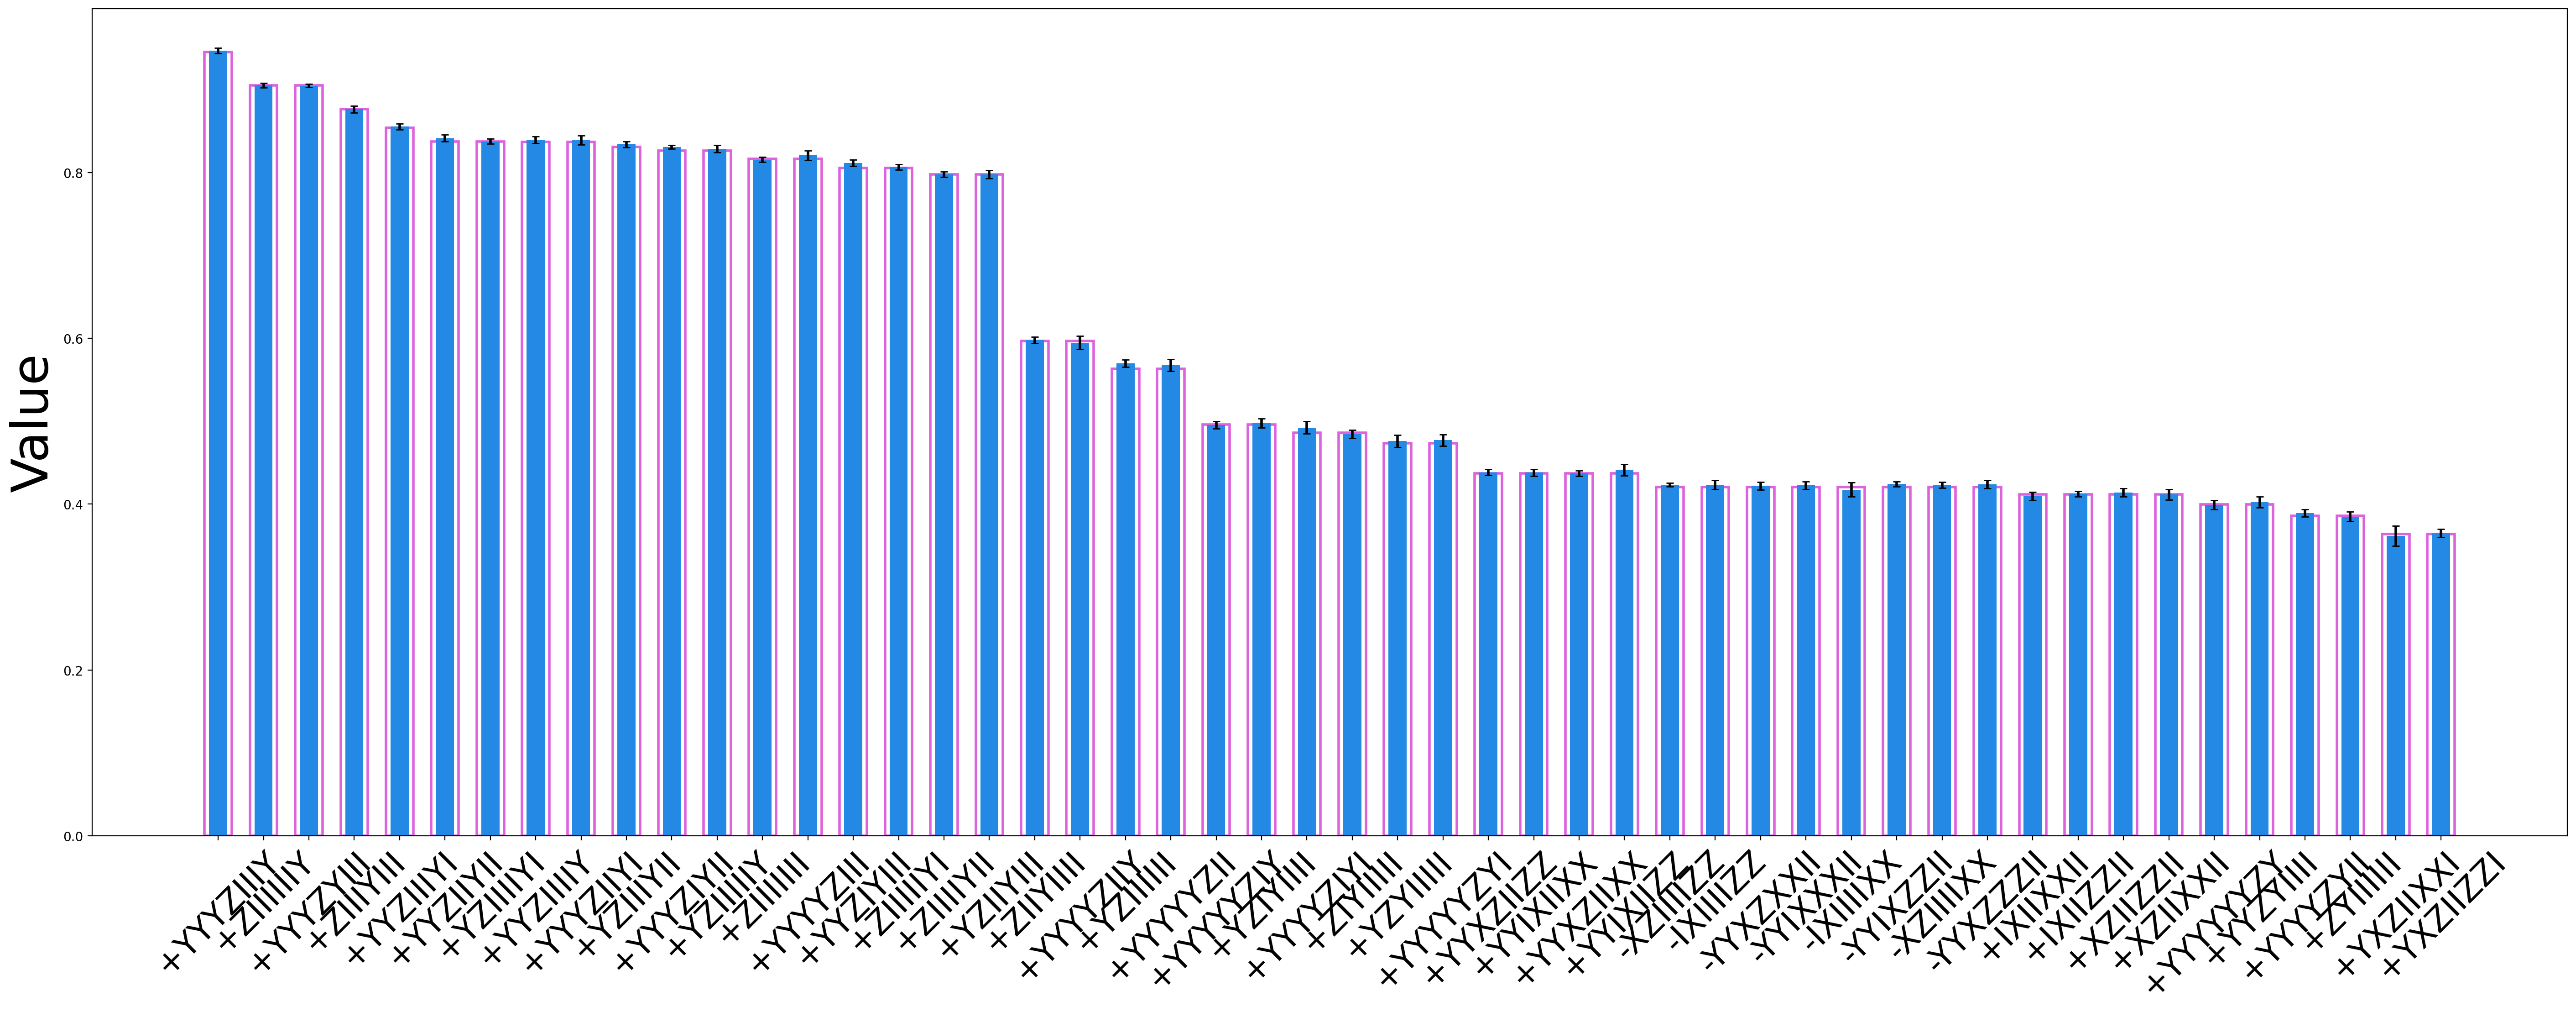

In [7]:
width=0.6
nplot = 8

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(35, 12), sharey=True, dpi=200)
rects2 = ax.bar(x, np.abs(orgHam), width, label='Original $s$', edgecolor='#dd62dd',linewidth=2, fill=False)
ax.set_ylabel('Value', size=40)

# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.tick_params(axis='x', rotation=45,labelsize=40)
ax.set_xticklabels([addSign(num2PauliLabel(int(labels[i])-1, nplot), signs[i]) for i in range(0, len(labels))],size=26)

error_attri = dict(elinewidth = 2, ecolor="black", capsize = 3)

rects1 = ax.bar(x, np.abs(reConHam), 0.4, label='Reconstructed $\hat{s}$',yerr=reStd,error_kw=error_attri, color='#2389e4')

plt.savefig("H4_new.svg")
plt.show()